# 从零开始的神经网络

## 1. 简单框架版

In [68]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

神经网络网络的基本架构：
- 单元/神经网络
- **权重/参数/连接**
- 偏置项

### 1.1 激活函数
把x轴上的数映射到一个区间中
激活函数的主要目的是制造非线性，有没有生物学解释其实不那么重要，函数光滑不光滑也没那么重要。
常见的激活函数：

In [69]:
x = np.linspace(-4, 4)

#### sigmoid
$$
\operatorname{sigmoid}(x)=\frac{1}{1+e^{-x}}
$$

在sigmod函数中我们可以看到，其输出是在(0,1)这个开区间内，可以联想到概率。sigmod函数可以想象成一个神经元的放电率，在中间斜率比较大的地方是神经元的敏感区，在两边斜率很平缓的地方是神经元的抑制区。
缺陷：

1) 当输入稍微远离了坐标原点，函数的梯度就变得很小了，几乎为零。在神经网络反向传播的过程中，我们都是通过微分的链式法则来计算各个权重w的微分的。当反向传播经过了sigmod函数，这个链条上的微分就很小很小了，况且还可能经过很多个sigmod函数，最后会导致权重w对损失函数几乎没影响，这样不利于权重的优化，这个问题叫做梯度饱和，也可以叫梯度弥散。

2) 函数输出不是以0为中心的，这样会使权重更新效率降低。对于这个缺陷，在斯坦福的课程里面有详细的解释。

3) sigmod函数要进行指数运算，这个对于计算机来说是比较慢的。

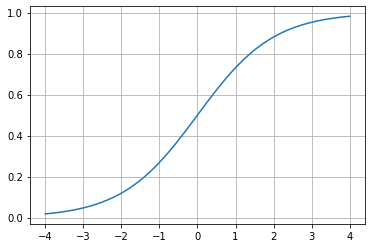

In [70]:
y_sigmoid = 1 / (1 + np.exp(-x))
plt.plot(x, y_sigmoid)
plt.grid()
plt.show()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#### Softmax

$$
P(y=i)=\frac{\exp \left(\sum_{d} w_{i d} x_{d}\right)}{\sum_{j} \exp \left(\sum_{d} w_{j d} x_{d}\right)}
$$

Softmax函数，或称归一化指数函数，是逻辑函数的一种推广。
Softmax函数实际上是有限项离散概率分布的梯度对数归一化。
softmax设计的初衷，是希望特征对概率的影响是乘性的。多类分类问题的目标函数常常选为cross-entropy(One-Hot)，即

$$L=-\sum_{k} t_{k} \log P(y=k)$$,

其中目标类的$t_{k}$等于1，其它类的$t_{k}$等于0。

在神经网络模型（最简单的logistic regression也可看成没有隐含层的神经网络）中，输出层第i个神经元的输入为

$$a_{i}=\sum_{d} w_{i d} x_{d}$$

神经网络是用error back-propagation(BP,误差反向传播)训练的，这个过程中有一个关键的量是

$$\partial L / \partial a_{i}$$

同时使用softmax和cross-entropy时，
$$\partial L / \partial a_{i}=P(y_{i})-t_{i}$$

这个形式非常简洁，而且与线性回归（采用最小均方误差目标函数）、两类分类（采用cross-entropy目标函数）时的形式一致。

多分类推荐先softmax，然后计算cross entropy loss；多标签推荐先sigmoid，再计算cross entropy loss。

还可以把每个类别单独看作一个二分类进行归一化，也就是先计算sigmoid，再计算cross entropy，即pytorch里面的[BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCEWithLogitsLoss)，像yolov3里面的多分类目标函数就是用的这种方式。

cross_entropy =$\[-\sum_{c=1}^My_{o,c}\log(p_{o,c})\]$

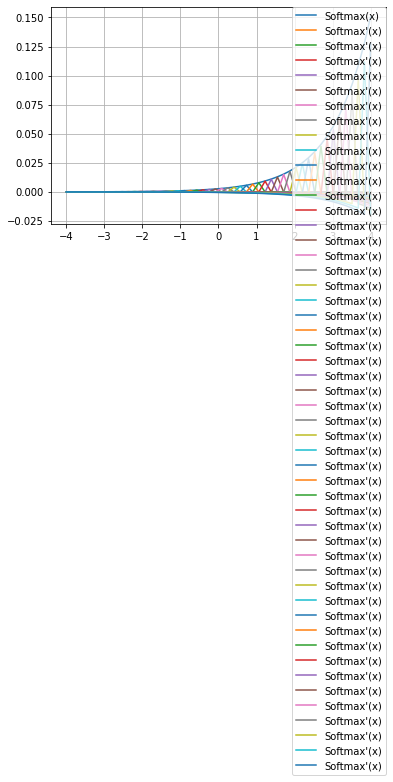

In [71]:
def softmax(x):
    exp = np.exp(x - x.max())
    return exp / exp.sum()


def d_softmax(x):
    sm = softmax(x)
    return np.diag(sm) - np.outer(sm, sm)

y_softmax = softmax(x)
y_softmax_erivative = d_softmax(x)
plt.plot(x,y_softmax,label="Softmax(x)")
# plt.plot(x, y_softmax_erivative, label="Softmax'(x)")
plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
plt.show()

#### TanHyperbolic（Tanh）
$$
\tanh (x)=\frac{\sinh (x)}{\cosh (x)}=\frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}=\frac{e^{2 x}-1}{e^{2 x}+1}
$$

$$
\tanh '(x)=1-\tanh(x)^2
$$

tanh是双曲正切函数，tanh函数和sigmod函数的曲线是比较相近的，咱们来比较一下看看。首先相同的是，这两个函数在输入很大或是很小的时候，输出都几乎平滑，梯度很小，不利于权重更新；不同的是输出区间，tanh的输出区间是在(-1,1)之间，而且整个函数是以0为中心的，这个特点比sigmod的好。

一般二分类问题中，隐藏层用tanh函数，输出层用sigmod函数。

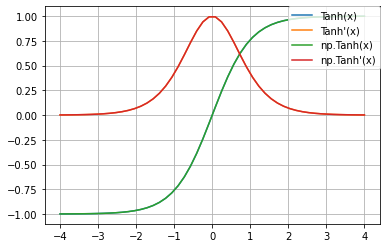

In [72]:
y_tanh = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
y_tanh_erivative = 1 - ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))) ** 2
plt.plot(x, y_tanh, label="Tanh(x)")
plt.plot(x, y_tanh_erivative, label="Tanh'(x)")
plt.plot(x, np.tanh(x), label="np.Tanh(x)")
plt.plot(x, 1 / (np.cosh(x)) ** 2, label="np.Tanh'(x)")
plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
plt.show()


def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

#### ReLU
$$
relu(x)=\left\{\begin{array}{ll}{x,} & {\text { if } x \geq 0} \\ {0,} & {\text { if } x<0}\end{array}\right. = \max (0, x)
$$

ReLU(Rectified Linear Unit)函数是目前比较火的一个激活函数，相比于sigmod函数和tanh函数，优点：

1) 在输入为正数的时候，不存在梯度饱和问题。

2) 计算速度要快很多。ReLU函数只有线性关系，不管是前向传播还是反向传播，都比sigmod和tanh要快很多。（sigmod和tanh要计算指数，计算速度会比较慢）

缺点：

1) 当输入是负数的时候，ReLU是完全不被激活的，这就表明一旦输入到了负数，ReLU就会死掉。这样在前向传播过程中，还不算什么问题，有的区域是敏感的，有的是不敏感的。但是到了反向传播过程中，输入负数，梯度就会完全到0，这个和sigmod函数、tanh函数有一样的问题。

2) 我们发现ReLU函数的输出要么是0，要么是正数，这也就是说，ReLU函数也不是以0为中心的函数。

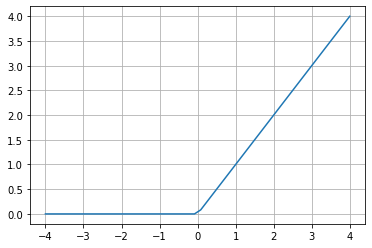

In [73]:
y_relu = np.array([0 * item if item < 0 else item for item in x])
plt.plot(x, y_relu)
plt.grid()
plt.show()


def relu(x):
    return np.array([0 * item if item < 0 else item for item in x])

#### ELU
$$
elu(x)=\left\{\begin{array}{cl}{x} & {, x>0} \\ {\alpha\left(e^{x}-1\right)} & {, x \leq 0}\end{array}\right.
$$

ELU函数是针对ReLU函数的一个改进型，相比于ReLU函数，在输入为负数的情况下，是有一定的输出的，而且这部分输出还具有一定的抗干扰能力。这样可以消除ReLU死掉的问题，不过还是有梯度饱和和指数运算的问题。

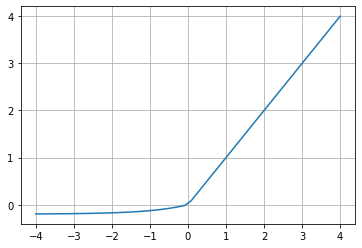

In [74]:
y_elu = np.array([0.2 * (np.exp(item) - 1) if item < 0 else item for item in x])
plt.plot(x, y_elu)
plt.grid()
plt.show()


def elu(x):
    return np.array([0.2 * (np.exp(item) - 1) if item < 0 else item for item in x])

#### Leaky ReLU（PReLU）
$$
p_relu(x)==\left\{\begin{array}{ll}{x,} & {\text  x \geq 0} \\ {ax,} & {\text x<0}\end{array}\right. =\max (a x, x)
$$

PReLU也是针对ReLU的一个改进型，在负数区域内，PReLU有一个很小的斜率，这样也可以避免ReLU死掉的问题。相比于ELU，PReLU在负数区域内是线性运算，斜率虽然小，但是不会趋于0，这算是一定的优势吧。

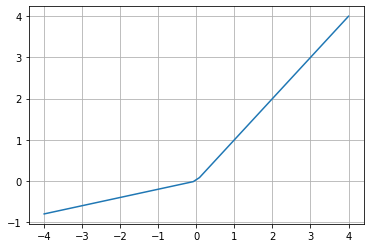

In [75]:
y_prelu = np.array([0.2 * item if item < 0 else item for item in x])
plt.plot(x, y_prelu)
plt.grid()
plt.show()


def prelu(x):
    return np.array([0.2 * item if item < 0 else item for item in x])

#### Softplus
$$
Softplus(x)=\log \left(e^{x}+1\right)
$$

softplus可以看作是ReLu的平滑，softplus和ReLu与脑神经元激活频率函数有神似的地方。
相比于早期的激活函数，softplus和ReLu更加接近脑神经元的激活模型。 

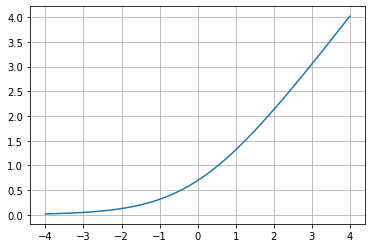

In [76]:
y_softplus = np.log(np.exp(x) + 1)
plt.plot(x, y_softplus)
plt.grid()
plt.show()


def softplus(x):
    return np.log(np.exp(x) + 1)

#### Softsign
$$
softsign(x)=\frac{x}{|x|+1}
$$

$$
softsign'(x)=\frac{1}{(|x|+1)^2}
$$

Softsign是Tanh 激活函数的另一个替代选择。
和Tanh一样，Softsign是反对称、去中心、可微分，并返回-1和1之间的值。
其更平坦的曲线与更慢的下降导数表明它可以更高效地学习，比tanh更好的解决梯度消失的问题。
另一方面，导数的计算比 Tanh 更麻烦，在实践中，可以深度用softsign替代tanh激活函数。

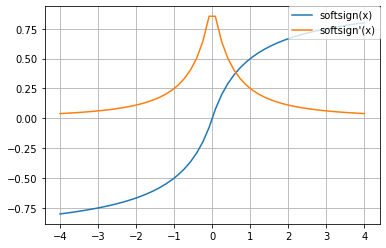

In [77]:
y_softsign = x / (abs(x) + 1)
y_softsign_erivative = 1 / (abs(x) + 1) ** 2
plt.plot(x, y_softsign, label="softsign(x)")
plt.plot(x, y_softsign_erivative, label="softsign'(x)")  #精度不够
plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
plt.show()


def softsign(x):
    return x / (abs(x) + 1)

#### 激活函数对比

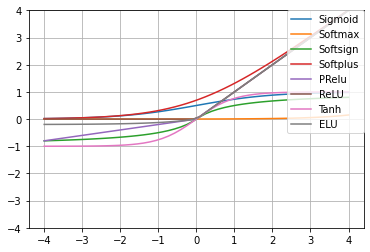

In [78]:
plt.plot(x, y_sigmoid, label="Sigmoid")
plt.plot(x, y_softmax, label="Softmax")
plt.plot(x, y_softsign, label="Softsign")
plt.plot(x, y_softplus, label="Softplus")
plt.plot(x, y_prelu, label="PRelu")
plt.plot(x, y_relu, label="ReLU")
plt.plot(x, y_tanh, label="Tanh")
plt.plot(x, y_elu, label="ELU")
plt.grid()
plt.ylim((-4, 4))
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
plt.show()